In [1]:
import csv
import math
import os
import cv2

from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
import keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATA_DIR = "images"

# 0.35, 0.5, 0.75, 1.0, 1.3, 1.4
ALPHA = 0.75

# 96, 128, 160, 192, 224
IMAGE_SIZE = 224

EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20

data = pd.read_csv('training.csv')
train, test = train_test_split(data, test_size=0.1, random_state=123)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train.to_csv('train.csv', index=False)
test.to_csv('validation.csv', index=False)

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

Using TensorFlow backend.


In [2]:
df = pd.read_csv('validation.csv')

val_coords = np.zeros((len(df),4))
val_images = np.zeros((len(df), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for index, row in df.iterrows():
    path = os.path.join(DATA_DIR, row['image_name'])
    x1 = row['x1']
    x2 = row['x2']
    y1 = row['y1']
    y2 = row['y2']

    img = Image.open(path)
    width, height = img.size

    val_coords[index, 0] = x1*IMAGE_SIZE / width
    val_coords[index, 1] = y1*IMAGE_SIZE / height
    val_coords[index, 2] = (x2 - x1)* IMAGE_SIZE / width
    val_coords[index, 3] = (y2 - y1)*IMAGE_SIZE / height 
    
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    pil_img = img
    img = np.array(img, dtype=np.float32)
    val_images[index] = preprocess_input(img.copy())
    pil_img.close()




In [3]:

class DataGenerator(Sequence):

    def __init__(self, csv_file,rnd_rescale=True, rnd_multiply=True, rnd_color=True, rnd_crop=True, rnd_flip=True,
                 batch_size = BATCH_SIZE, rnd_dice=True):
        self.paths = []
        self.coords = []
        self.batch_size = batch_size
        self.rnd_rescale = rnd_rescale
        self.rnd_multiply = rnd_multiply
        self.rnd_color = rnd_color
        self.rnd_crop = rnd_crop
        self.rnd_flip = rnd_flip
        self.rnd_dice = rnd_dice

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file)-1, 4))
            
        df = pd.read_csv(csv_file)

        for index, row in df.iterrows():
            path = os.path.join(DATA_DIR, row['image_name'])
            x1 = row['x1']
            x2 = row['x2']
            y1 = row['y1']
            y2 = row['y2']

            img = Image.open(path)
            width, height = img.size

            self.coords[index, 0] = x1
            self.coords[index, 1] = y1
            self.coords[index, 2] = x2 
            self.coords[index, 3] = y2 

            self.paths.append(path)
        
    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size//2:(idx + 1) * self.batch_size//2]
        coords = self.coords[idx * self.batch_size//2:(idx + 1) * self.batch_size//2].copy()
        batch_coords = np.zeros((self.batch_size,4))
        batch_images = np.zeros((self.batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        i = 0
        for j, f in enumerate(batch_paths):
            img = Image.open(f)
            x0,y0,x1,y1 = coords[j]
            image_width = img.width
            image_height = img.height
            img2 = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img2 = img2.convert('RGB')
            img2 = np.array(img2, dtype=np.float32)
            batch_images[i] = preprocess_input(img2.copy())
            
            batch_coords[i, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
            
            if self.rnd_dice:
                
                select = np.random.randint(5)
                
                if select==0 and self.rnd_rescale:
                    old_width = img.width
                    old_height = img.height

                    rescale = np.random.uniform(low=0.6, high=1.4)
                    new_width = int(old_width * rescale)
                    new_height = int(old_height * rescale)

                    img = img.resize((new_width, new_height))

                    x0 *= new_width / old_width
                    y0 *= new_height / old_height
                    x1 *= new_width / old_width
                    y1 *= new_height / old_height

                if select==1 and self.rnd_crop:
                    start_x = np.random.randint(0, high=np.floor(0.15 * img.width))
                    stop_x = img.width - np.random.randint(0, high=np.floor(0.15 * img.width))
                    start_y = np.random.randint(0, high=np.floor(0.15 * img.height))
                    stop_y = img.height - np.random.randint(0, high=np.floor(0.15 * img.height))

                    img = img.crop((start_x, start_y, stop_x, stop_y))

                    x0 = max(x0 - start_x, 0)
                    y0 = max(y0 - start_y, 0)
                    x1 = min(x1 - start_x, img.width)
                    y1 = min(y1 - start_y, img.height)

                    if np.abs(x1 - x0) < 5 or np.abs(y1 - y0) < 5:
                        print("\nWarning: cropped too much (obj width {}, obj height {}, img width {}, img height {})\n".format(x1 - x0, y1 - y0, img.width, img.height))

                if select==2 and self.rnd_flip:
                    elem = np.random.choice([0, 90, 180, 270, 1423, 1234])
                    if elem % 10 == 0:
                        x = x0 - img.width / 2
                        y = y0 - img.height / 2

                        x0 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                        y0 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                        x = x1 - img.width / 2
                        y = y1 - img.height / 2

                        x1 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                        y1 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                        img = img.rotate(-elem)
                    else:
                        if elem == 1423:
                            img = img.transpose(Image.FLIP_TOP_BOTTOM)
                            y0 = img.height - y0
                            y1 = img.height - y1

                        elif elem == 1234:
                            img = img.transpose(Image.FLIP_LEFT_RIGHT)
                            x0 = img.width - x0
                            x1 = img.width - x1

                image_width = img.width
                image_height = img.height

                tmp = x0
                x0 = min(x0, x1)
                x1 = max(tmp, x1)

                tmp = y0
                y0 = min(y0, y1)
                y1 = max(tmp, y1)

                x0 = max(x0, 0)
                y0 = max(y0, 0)

                y0 = min(y0, image_height)
                x0 = min(x0, image_width)
                y1 = min(y1, image_height)
                x1 = min(x1, image_width)

                if select==3 and self.rnd_color:
                    enhancer = ImageEnhance.Color(img)
                    img = enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

                    enhancer2 = ImageEnhance.Brightness(img)
                    img = enhancer.enhance(np.random.uniform(low=0.7, high=1.3))

                img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
                img = img.convert('RGB')
                pil_img = img
                img = np.array(img, dtype=np.float32)
                pil_img.close()
                
                if select==4 and self.rnd_multiply:
                    img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                    img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                    img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))

                batch_images[i+1] = preprocess_input(img.copy())

                batch_coords[i+1, 0] = x0 * IMAGE_SIZE / image_width
                batch_coords[i+1, 1] = y0 * IMAGE_SIZE / image_height
                batch_coords[i+1, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                batch_coords[i+1, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                
            i+=2
            
        return batch_images, batch_coords

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

            pred = np.maximum(pred, 0)

            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)

        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse

        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

        
class ValDataGenerator(Sequence):
    def __init__(self, csv_file, val_images, val_coords, batch_size = BATCH_SIZE):
        self.images = val_images
        self.coords = val_coords
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_images, batch_coords

def IOU(y_true, y_pred):
    diff_width = K.minimum(y_true[:,0] + y_true[:,2], y_pred[:,0] + y_pred[:,2]) - K.maximum(y_true[:,0], y_pred[:,0])
    diff_height = K.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3]) - K.maximum(y_true[:,1], y_pred[:,1])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = K.maximum(area_gt + area_pred - intersection, 0)

    #ntersection = K.sum(intersection * (union > 0))
    intersection = K.tf.where(union > 0, intersection, K.zeros_like(intersection))
    intersection = K.sum(intersection)
    union = K.sum(union)
    iou = (intersection / (union + epsilon()))
    return iou

def IOU_loss(y_true, y_pred):
    return -IOU(y_true, y_pred)

In [22]:
def create_model(pretrained_weights = None,input_size = (IMAGE_SIZE,IMAGE_SIZE,3)):
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    mobnet = MobileNetV2(input_tensor=conv9 ,input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights=None)
    
    x = mobnet.outputs[0]
    x = AveragePooling2D(strides=(2,2))(x)
    x = Conv2D(256, kernel_size=3, name="incep1", padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=3, name="incep2", padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(4, kernel_size=3, name="incep3")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4)(x)
    x = Reshape((4,))(x)
    
    model = Model(inputs = inputs, outputs = x)

    return model

In [23]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 224, 224, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_212[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_213[0][0]                 
__________________________________________________________________________________________________
conv2d_214

In [9]:
train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = Validation(generator=ValDataGenerator(VALIDATION_CSV, val_images, val_coords))

In [28]:

model.compile(loss="mean_absolute_error", optimizer="adam", metrics=['accuracy', IOU])

checkpoint = ModelCheckpoint("maxpool-mobilenet-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")


In [29]:
model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[validation_datagen, reduce_lr, stop, checkpoint],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)


Epoch 1/500
245/394 [=================>............] - ETA: 35s - loss: 16.5467 - acc: 0.8700 - IOU: 0.6597

393/394 [============================>.] - ETA: 0s - loss: 14.5025 - acc: 0.8849 - IOU: 0.6917 - val_iou: 0.5597 - val_mse: 556.9409

Epoch 00001: val_iou improved from -inf to 0.55970, saving model to maxpool-mobilenet-0.56.h5
394/394 [==============================] - 152s 387ms/step - loss: 14.4913 - acc: 0.8848 - IOU: 0.6919
Epoch 2/500
 87/394 [=====>........................] - ETA: 52s - loss: 9.3965 - acc: 0.9228 - IOU: 0.7773

393/394 [============================>.] - ETA: 0s - loss: 9.5571 - acc: 0.9259 - IOU: 0.7780 - val_iou: 0.6606000000000001 - val_mse: 480.197

Epoch 00002: val_iou improved from 0.55970 to 0.66060, saving model to maxpool-mobilenet-0.66.h5
394/394 [==============================] - 69s 176ms/step - loss: 9.5594 - acc: 0.9260 - IOU: 0.7780
Epoch 3/500
393/394 [============================>.] - ETA: 0s - loss: 8.2149 - acc: 0.9307 - IOU: 0.8057 - va

393/394 [============================>.] - ETA: 0s - loss: 3.5656 - acc: 0.9705 - IOU: 0.9040 - val_iou: 0.9101 - val_mse: 152.2132

Epoch 00046: val_iou improved from 0.90660 to 0.91010, saving model to maxpool-mobilenet-0.91.h5
394/394 [==============================] - 69s 174ms/step - loss: 3.5638 - acc: 0.9706 - IOU: 0.9040
Epoch 47/500
 71/394 [====>.........................] - ETA: 54s - loss: 3.2567 - acc: 0.9723 - IOU: 0.9080

393/394 [============================>.] - ETA: 0s - loss: 3.5075 - acc: 0.9690 - IOU: 0.9050 - val_iou: 0.9122 - val_mse: 150.00390000000002

Epoch 00047: val_iou improved from 0.91010 to 0.91220, saving model to maxpool-mobilenet-0.91.h5
394/394 [==============================] - 69s 175ms/step - loss: 3.5070 - acc: 0.9689 - IOU: 0.9050
Epoch 48/500
393/394 [============================>.] - ETA: 0s - loss: 3.4694 - acc: 0.9684 - IOU: 0.9054 - val_iou: 0.9109 - val_mse: 148.6719

Epoch 00048: val_iou did not improve from 0.91220
394/394 [==============

Epoch 70/500
393/394 [============================>.] - ETA: 0s - loss: 2.9779 - acc: 0.9746 - IOU: 0.9157 - val_iou: 0.914 - val_mse: 149.69070000000002

Epoch 00070: val_iou did not improve from 0.91440
394/394 [==============================] - 68s 173ms/step - loss: 2.9814 - acc: 0.9745 - IOU: 0.9157
Epoch 71/500
393/394 [============================>.] - ETA: 0s - loss: 2.9753 - acc: 0.9722 - IOU: 0.9158 - val_iou: 0.9113 - val_mse: 149.0693

Epoch 00071: val_iou did not improve from 0.91440
394/394 [==============================] - 69s 176ms/step - loss: 2.9807 - acc: 0.9722 - IOU: 0.9157
Epoch 72/500
325/394 [=======================>......] - ETA: 11s - loss: 2.9538 - acc: 0.9712 - IOU: 0.9163

393/394 [============================>.] - ETA: 0s - loss: 2.9853 - acc: 0.9722 - IOU: 0.9158 - val_iou: 0.9124 - val_mse: 149.57410000000002

Epoch 00072: val_iou did not improve from 0.91440
394/394 [==============================] - 69s 175ms/step - loss: 2.9864 - acc: 0.9721 - IOU: 0

Epoch 115/500
393/394 [============================>.] - ETA: 0s - loss: 2.8694 - acc: 0.9730 - IOU: 0.9180 - val_iou: 0.9136000000000001 - val_mse: 149.57070000000002

Epoch 00115: val_iou did not improve from 0.91440
394/394 [==============================] - 68s 174ms/step - loss: 2.8702 - acc: 0.9727 - IOU: 0.9180
Epoch 116/500
393/394 [============================>.] - ETA: 0s - loss: 2.8928 - acc: 0.9717 - IOU: 0.9180 - val_iou: 0.9136000000000001 - val_mse: 149.531

Epoch 00116: val_iou did not improve from 0.91440
394/394 [==============================] - 69s 174ms/step - loss: 2.8925 - acc: 0.9718 - IOU: 0.9180
Epoch 117/500
236/394 [================>.............] - ETA: 26s - loss: 2.8968 - acc: 0.9721 - IOU: 0.9174

393/394 [============================>.] - ETA: 0s - loss: 2.9277 - acc: 0.9734 - IOU: 0.9169 - val_iou: 0.9136000000000001 - val_mse: 149.5508

Epoch 00117: val_iou did not improve from 0.91440
394/394 [==============================] - 69s 175ms/step - loss: 

In [3]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.mobilenetv2 import preprocess_input

WEIGHTS_FILE = "mobilenetV2-no-weights-0.91.h5"
IMAGES = "images/*png"

model = create_model()
model.load_weights(WEIGHTS_FILE)


Using TensorFlow backend.


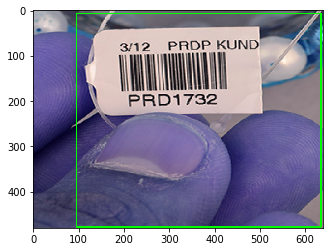

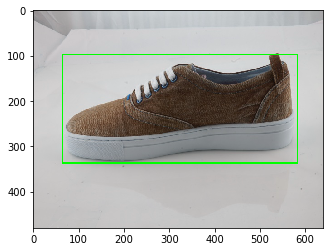

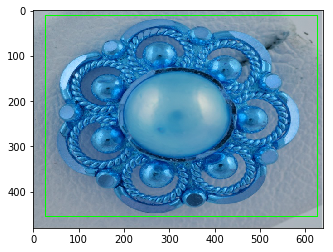

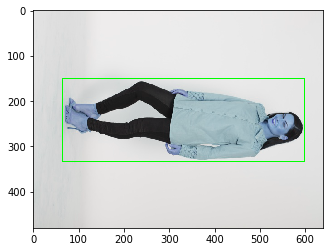

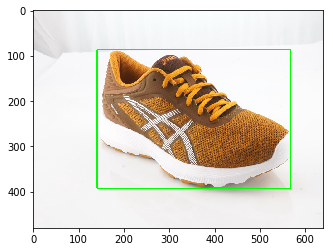

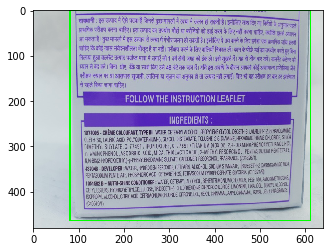

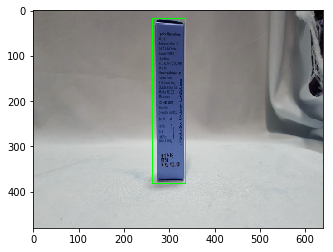

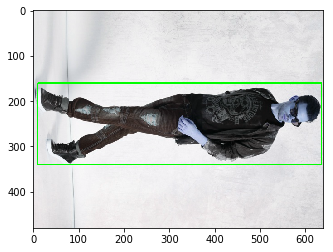

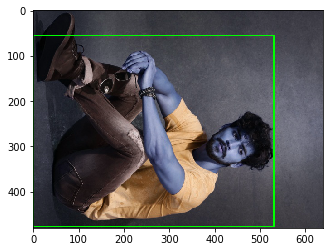

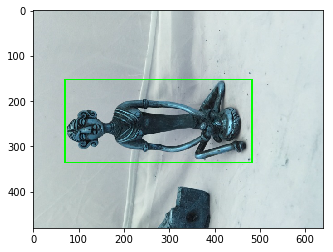

In [4]:

for filename in glob.glob(IMAGES)[8000:8010]:
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x0 = int(region[0] * image_width / IMAGE_SIZE)
    y0 = int(region[1] * image_height / IMAGE_SIZE)

    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 255, 0), 2)
    plt.imshow(unscaled)
    plt.show()

In [5]:
sample = pd.read_csv("test.csv")
sample.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [9]:
for index, row in sample.iterrows():
    unscaled = cv2.imread('images/'+row['image_name'])
    image_height, image_width, _ = unscaled.shape

    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    region = model.predict(x=np.array([feat_scaled]))[0]

    x1 = (region[0] * image_width / IMAGE_SIZE)
    y1 = (region[1] * image_height / IMAGE_SIZE)

    x2 = ((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y2 = ((region[1] + region[3]) * image_height / IMAGE_SIZE)

    sample.iloc[index,1] = x1
    sample.iloc[index,2] = x2
    sample.iloc[index,3] = y1
    sample.iloc[index,4] = y2

sample.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,232.934222,443.137905,87.840108,405.383606
1,1473231475010DeeplearnS11276.png,73.057654,567.362409,136.734295,351.654543
2,JPEG_20161205_135307_1000155917326.png,147.640566,495.844334,55.824088,436.824908
3,JPEG_20160711_123440_1000518778437.png,213.478285,467.041452,91.416558,412.423750
4,JPEG_20160803_115329_100034020722.png,137.865928,497.681449,47.736981,433.489870


In [10]:
sample.to_csv('prediction_mnv2_deci.csv', index=False)

In [20]:
model.compile(loss="mean_absolute_error", optimizer="adadelta", metrics=['accuracy'])

In [3]:
x1=231.0
x2=440.0
y1=88.0
y2=408.0

In [30]:
model.load_weights('mobilenetV2-no-weights-all_layers-0.91.h5')